In [1]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import numpy.random as rnd
from scipy.constants import physical_constants

c = physical_constants['speed of light in vacuum'][0]
alpha = physical_constants['fine-structure constant'][0]
m_e = physical_constants['electron mass'][0]
h = physical_constants['Planck constant'][0]
hbar = physical_constants['reduced Planck constant'][0]
alpha = physical_constants['fine-structure constant'][0]
k_B = physical_constants['Boltzmann constant'][0]
g = physical_constants['standard acceleration of gravity'][0]
u = physical_constants['atomic mass constant'][0]
m_Rb87 = 86.909180520*u

# Import trap characteristics

In [3]:
#Physical parameters   - everything in S.I, except distances in µm
lambda_l = 820*10**-9   #in m
omega_l = 2*np.pi*c/lambda_l #rad/s

#proportionality factor b/w trapping energy & intensity
#E = beta*I, I in W/m^2, E in J
beta = 1/alpha * h /(m_e * omega_l**2)

#rescale height of the trap, by defining the temperature at which the atoms escape (along diagonal axes)
T_escape = 40*10**-6
#T_max computed approximately as 4 times the escape temperature
T_max = 4*T_escape #to renormalize the whole trap power

#Load the pre-computed bob intensity profiles
#Regular Bob
#bob_file = open('bob_profile.pkl', 'rb')
#'Light-filled' Bob
bob_file = open('high_bob_profile.pkl', 'rb')
bob_data = pickle.load(bob_file)
size_pix_trans = bob_data['pix_trans']*10**-6   #in m
size_pix_z = bob_data['pix_z']*10**-6           #in m
#P0 = bob_data['P0']                             #in W

bob_array = bob_data['array']   #in W/m^2
#renormalize via the defined escape temperature
bob_array = bob_array*(T_max*k_B/beta) / (np.amax(bob_array))
N_pix_trans, N_pix_z = np.shape(bob_array)[0], np.shape(bob_array)[2]

# Define the energetic quantities

In [4]:
def cart_to_indexes(x,y,z):
    """
    converts (x,y,z) - cartesian coordinates, origin as center of bob, in m
    into indices in the imported Bob intensity array
    """
    i = int(N_pix_trans//2 + x/(size_pix_trans))
    j = int(N_pix_trans//2 + y/(size_pix_trans))
    k = int(N_pix_z//2 + z/(size_pix_z))
    
    return i,j,k

def I_bob(x, y, z):
    """
    returns, at point (x,y,z) - taking center of bob as origin - the intensity, in W/m^2
    """
    #return (x**2 + y**2 + z**2)*10**16
    i,j,k = cart_to_indexes(x,y,z)
    if(i<0 or j<0 or k<0):
        return 0
    elif(i>=N_pix_trans-1 or j>=N_pix_trans-1 or k>=N_pix_z):
        return 0
    else:
        return bob_array[i,j,k]
    
def E(x,y,z):
    """
    returns the potential energy at point (x,y,z), in J
    """
    return beta*I_bob(x,y,z)


def E_temp(x,y,z):
    """
    returns the potential energy at point (x,y,z), in µK
    """
    return beta*I_bob(x,y,z)/k_B *10**6

def dx_E(x, y, z):
    """
    gradient of energy profile along x axis
    """
    #return 2*x*10**16 *beta
    return (E(x+size_pix_trans/2, y, z) - E(x-size_pix_trans/2, y, z))/(size_pix_trans)

def dy_E(x, y, z):  
    """
    gradient of energy profile along y axis
    """  
    #return 2*y*10**16 *beta
    return (E(x, y+size_pix_trans/2, z) - E(x, y-size_pix_trans/2, z))/(size_pix_trans)
    
def dz_E(x, y, z):  
    """
    gradient of energy profile along z axis
    """
    #return 2*z*10**16 *beta
    return (E(x, y, z+size_pix_z/2) - E(x, y, z-size_pix_z/2))/(size_pix_z)

# Quick check: plot of the profile

Text(0, 0.5, 'U (µK)')

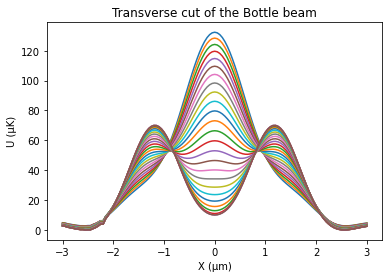

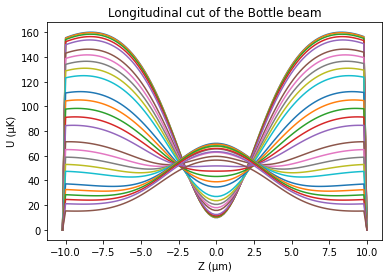

In [5]:
N_x = 121
Xs = np.linspace(-3, 3, N_x)*10**-6

plt.figure()
for z in np.linspace(-5*10**-6, 0, 26):
    U = np.empty(N_x)
    for i in range(N_x):
        U[i] = E_temp(Xs[i], 0, z)
    plt.plot(Xs*10**6, U)
plt.title('Transverse cut of the Bottle beam')
plt.xlabel('X (µm)')
plt.ylabel('U (µK)')

N_z = 101
Zs = np.linspace(-10.2, 10, N_z)*10**-6
plt.figure()
for x in np.linspace(0, 1.5*10**-6, 26):
    U = np.empty(N_z)
    for i in range(N_z):
        U[i] = E_temp(x, 0, Zs[i])
    plt.plot(Zs*10**6, U)
plt.title('Longitudinal cut of the Bottle beam')
plt.xlabel('Z (µm)')
plt.ylabel('U (µK)')

# Define the working class

In [6]:
class Atoms(object):
    
    def __init__(self, N_atoms, T, w_0, x_0, z_0):
        """
        Parameters
        ----------
        N_atoms : int
            The number of atoms to instantiate in the simulation.
        T : float
            The temperature, in K
        w_0: float
            initial spatial distribution, in m
        x_0, z_0: initial offsets in the cloud position, in m
        """
        
        self.N_atoms = N_atoms
        
        self.T = T
    
        #Not used, to be precised
        #sigma_r = np.sqrt(k_B * T / m_Rb87 / omega_r**2) # std dev of position along x, y
        #sigma_z = np.sqrt(k_B * T / m_Rb87 / omega_z**2) # std dev of position along z
        sigma_v = np.sqrt(k_B * self.T / m_Rb87) # std dev of velocity along an axis

        self.x_positions = np.random.normal(x_0, w_0, N_atoms)
        self.y_positions = np.random.normal(0, w_0, N_atoms)
        self.z_positions = np.random.normal(z_0, w_0, N_atoms)
        
        self.x_velocities = np.random.normal(0, sigma_v, N_atoms)
        self.y_velocities = np.random.normal(0, sigma_v, N_atoms)
        self.z_velocities = np.random.normal(0, sigma_v, N_atoms)
        
        self.potential_energies = np.empty(N_atoms)
        
        self.x_forces = np.empty(N_atoms)
        self.y_forces = np.empty(N_atoms)
        self.z_forces = np.empty(N_atoms)
        
        for at in range(self.N_atoms):
            self.potential_energies[at] = E_temp(self.x_positions[at],self.y_positions[at],self.z_positions[at])
            
            self.x_forces[at] = - dx_E(self.x_positions[at], self.y_positions[at], self.z_positions[at])  #N=J/m
            self.y_forces[at] = - dy_E(self.x_positions[at], self.y_positions[at], self.z_positions[at]) - m_Rb87*g
            self.z_forces[at] = - dz_E(self.x_positions[at], self.y_positions[at], self.z_positions[at]) 

        self.time = 0

            
    def step_trap(self, dt):
        """
        Computes the evolution, over a time step dt, of the atomic positions,
        with the trap ON
        dt: time step for integrating equations of motion, in s
        """
        
        #Update of the positions
        self.x_positions += dt * self.x_velocities
        self.y_positions += dt * self.y_velocities
        self.z_positions += dt * self.z_velocities
        
        
        for at in range(self.N_atoms):
            #update of the potential energies at the new positions
            #self.potential_energies[at] = E_temp(self.x_positions[at], self.y_positions[at], self.z_positions[at])
            
            #update the forces according to the new positions
            self.x_forces[at] = -dx_E(self.x_positions[at], self.y_positions[at], self.z_positions[at])
            self.y_forces[at] = -dy_E(self.x_positions[at], self.y_positions[at], self.z_positions[at]) - m_Rb87*g
            self.z_forces[at] = -dz_E(self.x_positions[at], self.y_positions[at], self.z_positions[at])
            
            #update velocities according to new forces
            self.x_velocities[at] += dt *self.x_forces[at]/m_Rb87
            self.y_velocities[at] += dt *self.y_forces[at]/m_Rb87
            self.z_velocities[at] += dt *self.z_forces[at]/m_Rb87
 
            
        self.time += dt
        
    def step_free(self, dt):        
        """
        Computes the evolution, over a time step dt, of the atomic positions,
        with the trap OFF
        dt: time step for integrating equations of motion, in s
        """
        
        self.x_positions += dt * self.x_velocities
        self.y_positions += dt * self.y_velocities
        self.z_positions += dt * self.z_velocities
        
        
        for at in range(self.N_atoms):
            #self.potential_energies[at] = E_temp(self.x_positions[at], self.y_positions[at], self.z_positions[at])
            
            #still update the forces as if the trap were here, in case it is later on turned ON
            self.x_forces[at] = -dx_E(self.x_positions[at], self.y_positions[at], self.z_positions[at])
            self.y_forces[at] = -dy_E(self.x_positions[at], self.y_positions[at], self.z_positions[at]) - m_Rb87*g
            self.z_forces[at] = -dz_E(self.x_positions[at], self.y_positions[at], self.z_positions[at])

        self.time += dt
        
    def trapped_fraction(self):
        """
        return the fraction of the initial atoms that are still trapped
        """
        frac = 0
        for at in range(self.N_atoms):
            r = np.sqrt(self.x_positions[at]**2 + self.y_positions[at]**2)
            #if the atom is outside of the central halo, regardless of z
            if(r<2*10**-6):
                frac+=1
        return frac/self.N_atoms
    
    
def sequence_evolution(atoms, times_off, time_step):
    """
    Computes the evolution in a sequence-like manner, with the trap on and off
    at differents times

    Parameters
    ----------
    atoms: object of the class 'Atoms'
    times_off: times over which the trap will be off; series of n 'gates'
        [t1, t2, t3, t4, ..., t2n-1, t2n, tf] in seconds,
        trap off b/w t1 and t2, then b/w t3 and t4, etc and on again b/w t2n and tf
    time_step: the time step to run the evolution
    """
    #number of extinctions
    N_ext = np.shape(times_off)[0]//2

    #loop over the number of times we turn the trap OFF
    for ext in range(N_ext):
        #number of time steps with the trap ON
        N_steps_trap = int((times_off[2*ext] - atoms.time)//time_step)
        #number of time steps with the trap OFF
        N_steps_free = int((times_off[2*ext + 1] - times_off[2*ext])//time_step)

        #evolve with trap ON
        for _ in range(N_steps_trap):
            atoms.step_trap(time_step)
        #evolve with trap OFFF
        for _ in range(N_steps_free):
            atoms.step_free(time_step) 
    
    #last stretch of evolution with the trap ON (final recapture)
    N_steps_trap = int((times_off[-1] - atoms.time)//time_step)
    for _ in range(N_steps_trap):
        atoms.step_trap(time_step)

# Run a single simulation

Text(0, 0.5, 'z positions (µm)')

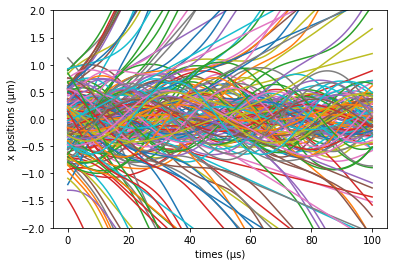

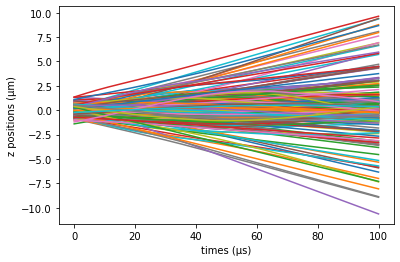

In [7]:
#Computes the evolution with the trap ON, over a given period of time

N_atoms = 200
T =  20 *10**-6   #K
x_0, z_0 = 0, 0    #piosition offsets in the trap, in m
w_0 = 0.5*10**-6   #initial standard deviation for the positions, in m

time_step = 0.1*10**-6  #time step over which the equations of motion are integrated, <0.1*10**-6s is fine i think

tf = 100*10**-6   #time up to which to compute the evolution, in s

N_steps = int(tf//time_step)
#arrays to store the positions over time
res_x = np.empty((N_atoms, N_steps))
res_z = np.empty((N_atoms, N_steps))

atoms = Atoms(N_atoms, T, w_0, x_0, z_0)


for step in range(N_steps):
    atoms.step_trap(time_step)
    for at in range(N_atoms):
        res_x[at, step] = atoms.x_positions[at]
        res_z[at, step] = atoms.z_positions[at]

#plot x positions over time
plt.figure()
times = np.linspace(0, tf, N_steps)*10**6
for at in range(N_atoms):
    plt.plot(times, res_x[at,:]*10**6) 
plt.xlabel('times (µs)')
plt.ylabel('x positions (µm)')
plt.ylim(-2,2)

#plot z positions over time
plt.figure()
times = np.linspace(0, tf, N_steps)*10**6
for at in range(N_atoms):
    plt.plot(times, res_z[at,:]*10**6)
plt.xlabel('times (µs)')
plt.ylabel('z positions (µm)')

# Single release-recapture experiment

In [ ]:
N_atoms = 200
T =  20 *10**-6   #K
x_0, z_0 = 0.*10**-6, 2.3*10**-6    #position offsets in the trap, in m
w_0 = 0.1*10**-6   #initial standard deviation for the positions, in m

time_step = 0.1*10**-6 #time step over which the equations of motion are integrated, <0.1*10**-6s is fine i think


first_start_trap_off = 10*10**-6  #first 'start' TRAP OFF
delay_trap_off = 15*10**-6        #duration TRAP OFF


N_seq_steps = 61   #number of scan values
increment = 8*10**-6  #increment between scan values (as defined in Cesar seq. manager)

#total duration of the sequence
tf = first_start_trap_off + N_seq_steps*increment + delay_trap_off + 20*10**-6

#array to store the result - recaptured fraction at each 'start TRAP OFF'
res_frac = np.empty(N_seq_steps)

for seq in range(N_seq_steps):
    #start TRAP OFF
    t_1 = first_start_trap_off+ seq*increment
    #end TRAP OFF
    t_2 = t_1 + delay_trap_off

    times_off = np.array([t_1, t_2, tf])

    atoms = Atoms(N_atoms, T, w_0, x_0, z_0)
    sequence_evolution(atoms, times_off, time_step)
    res_frac[seq] = atoms.trapped_fraction()


## plot the results

In [ ]:
plt.plot(np.linspace(first_start_trap_off,
                     first_start_trap_off + N_seq_steps*increment,
                     N_seq_steps)*10**6, 
         res_frac, 'o-')
plt.ylim(0,1)
plt.ylabel('Trapped fraction')
plt.xlabel('Start time trap OFF (µs)')

## save the results

In [56]:
fname = 'DarkBob_Nat=' + str(N_atoms) + '_z0=' + str(z_0*10**6) + '_trapOFF=' + str(np.round(delay_trap_off*10**6)) + '.txt'
print(fname)
np.savetxt('Precap_' + fname, res_frac)
np.savetxt('times_' + fname, np.linspace(first_start_trap_off,
                     first_start_trap_off + N_seq_steps*increment,
                     N_seq_steps)*10**6)

DarkBob_Nat=500_x0=0.3_trapOFF=15.0.txt


# Double release-recapture sequence - as done for the tweezers

In [46]:
N_atoms = 200
T =  25 *10**-6   #K
x_0, z_0 = 0, 0    #m
w_0 = 0.1*10**-6   #m

time_step = 0.05*10**-6

N_seq_steps = 26
increment = 2*10**-6

start_trap_off_1 = 10*10**-6
delay_trap_off_1 = 20*10**-6

first_start_trap_off_2 = 31*10**-6
delay_trap_off_2 = 15*10**-6

tf = first_start_trap_off_2 + N_seq_steps*increment + delay_trap_off_2 + 20*10**-6

res_frac = np.empty(N_seq_steps)

for seq in range(N_seq_steps):
    
    t_1 = start_trap_off_1

    t_2 = t_1 + delay_trap_off_1

    t_3 = first_start_trap_off_2 + seq*increment
    t_4 = first_start_trap_off_2 + delay_trap_off_2


    times_off = np.array([t_1, t_2, t_3, t_4, tf])

    atoms = Atoms(N_atoms, T, w_0, x_0, z_0)
    sequence_evolution(atoms, times_off, time_step)
    res_frac[seq] = atoms.trapped_fraction()


Text(0.5, 0, 'Start time trap OFF 2 (µs)')

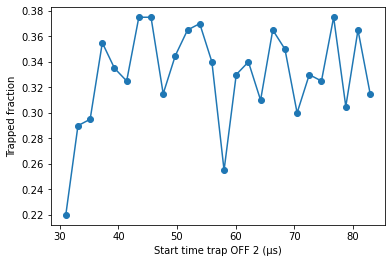

In [48]:
plt.plot(np.linspace(first_start_trap_off_2,
                     first_start_trap_off_2 + N_seq_steps*increment,
                     N_seq_steps)*10**6, 
         res_frac, '-o')

plt.ylabel('Trapped fraction')
plt.xlabel('Start time trap OFF 2 (µs)')